In [38]:
# Importing neccessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter
# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

**1. Data Preprocessing:**

a)Load the provided dataset and perform initial data exploration.

In [39]:
data=pd.read_csv('customer_churn_large_dataset.csv')
data['Gender']=data['Gender'].str.lower()
data['Location']=data['Location'].str.lower()
data.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,male,los angeles,17,73.36,236,0
1,2,Customer_2,62,female,new york,1,48.76,172,0
2,3,Customer_3,24,female,los angeles,5,85.47,460,0
3,4,Customer_4,36,female,miami,3,97.94,297,1
4,5,Customer_5,46,female,miami,19,58.14,266,0


In [40]:
data.dtypes

CustomerID                      int64
Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

From analysis the dataset, we notice that some of the independent features are in numerical and most of feature are in categorical feature. Seperate into numerical and categorical data for EDA parts

In [41]:
# numerical feature
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 6
Numerical feature are:
 {'CustomerID', 'Subscription_Length_Months', 'Churn', 'Monthly_Bill', 'Total_Usage_GB', 'Age'}


In [42]:
# Categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')

Count of Categorical feature: 3
Categorical feature are:
 {'Gender', 'Location', 'Name'}


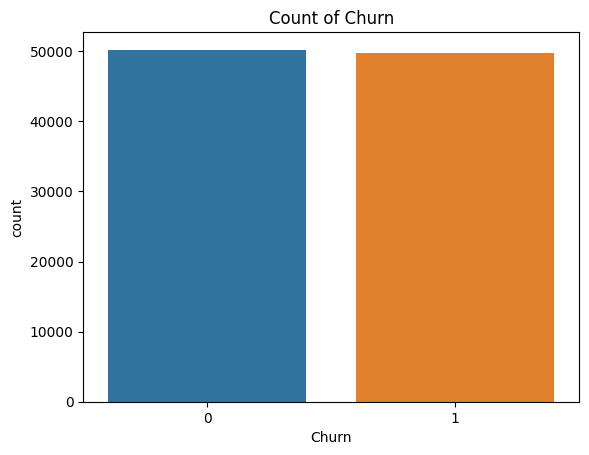

In [43]:
# plotting with target feature
sns.countplot(data=data, x='Churn')
plt.title('Count of Churn')
plt.show()

In [44]:
l1 = data.loc[data['Churn']== 'Yes'].count()[0]
print(f"Pecentage of Left: {l1/len(data['Churn'])}")
print(data.Churn.value_counts())

Pecentage of Left: 0.0
Churn
0    50221
1    49779
Name: count, dtype: int64


b)Handle missing data and outliers.

In [45]:
data.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In this dataset there is no null values, so we dont want to perform Handling missing values.

Checking Outlier

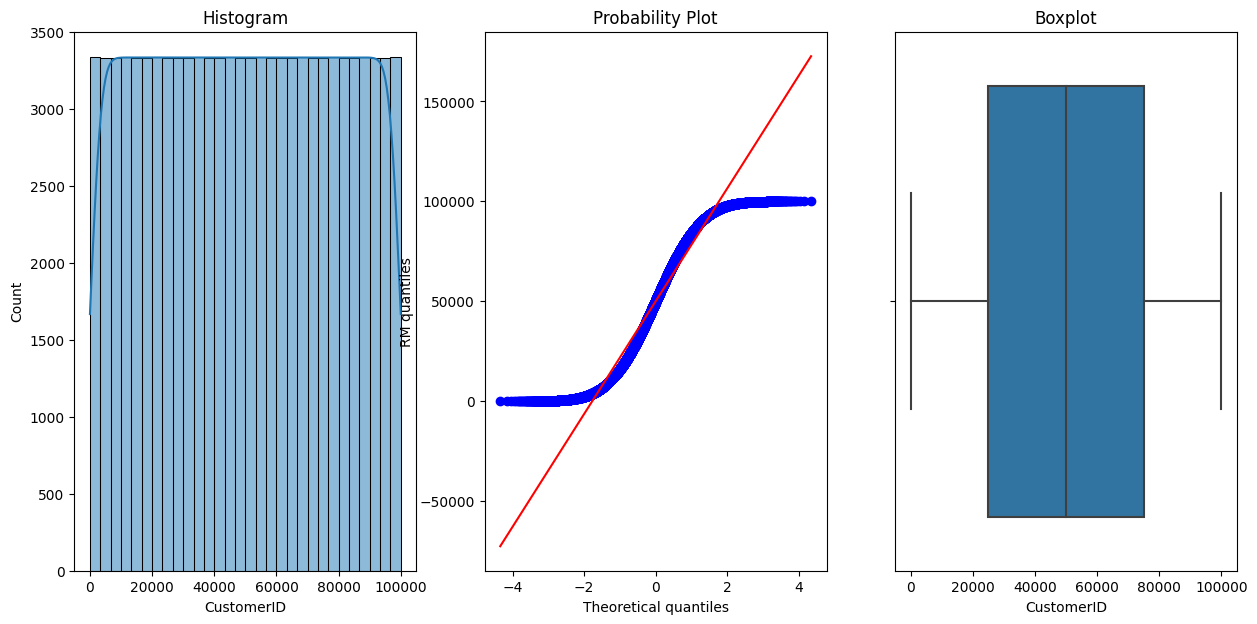

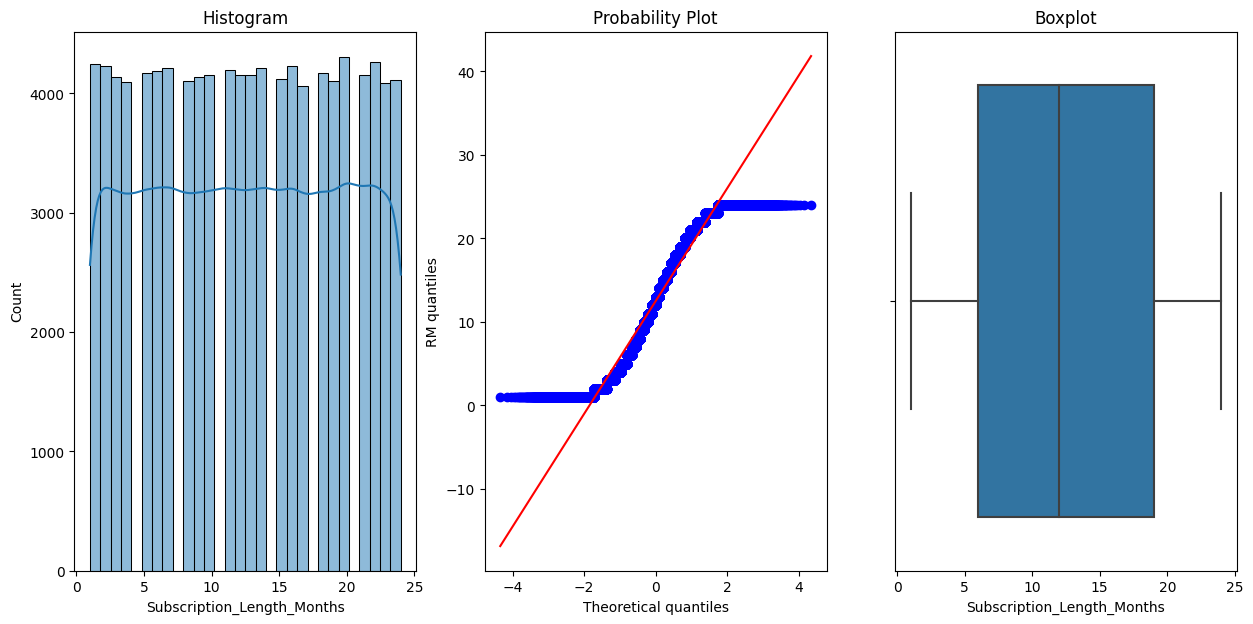

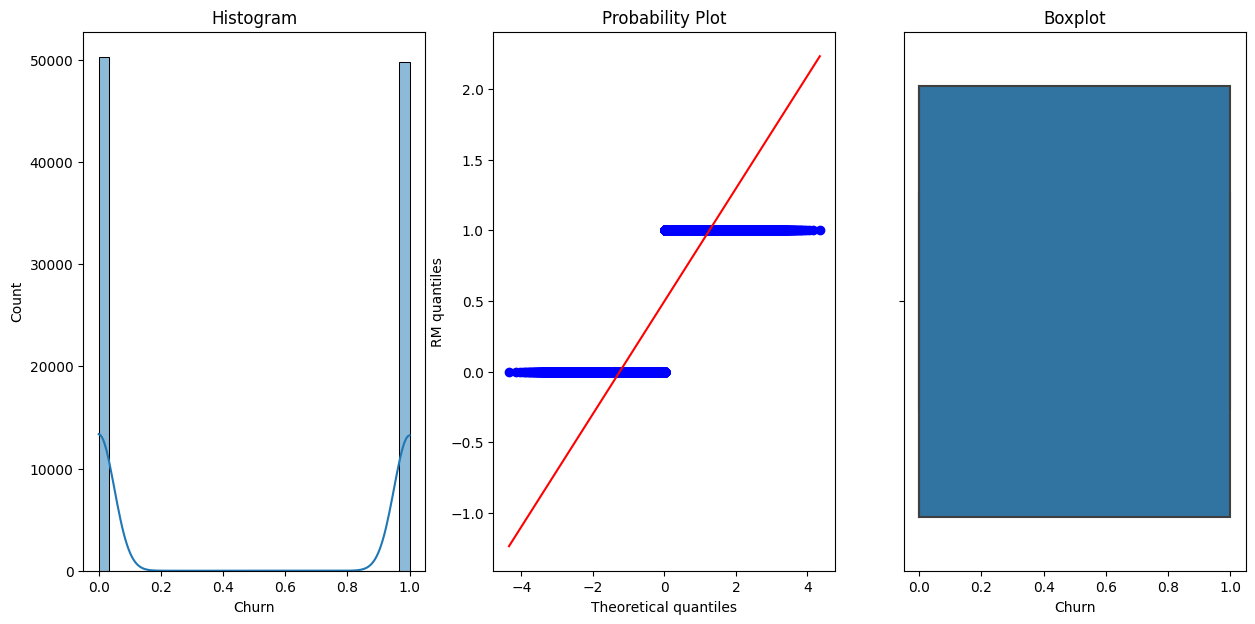

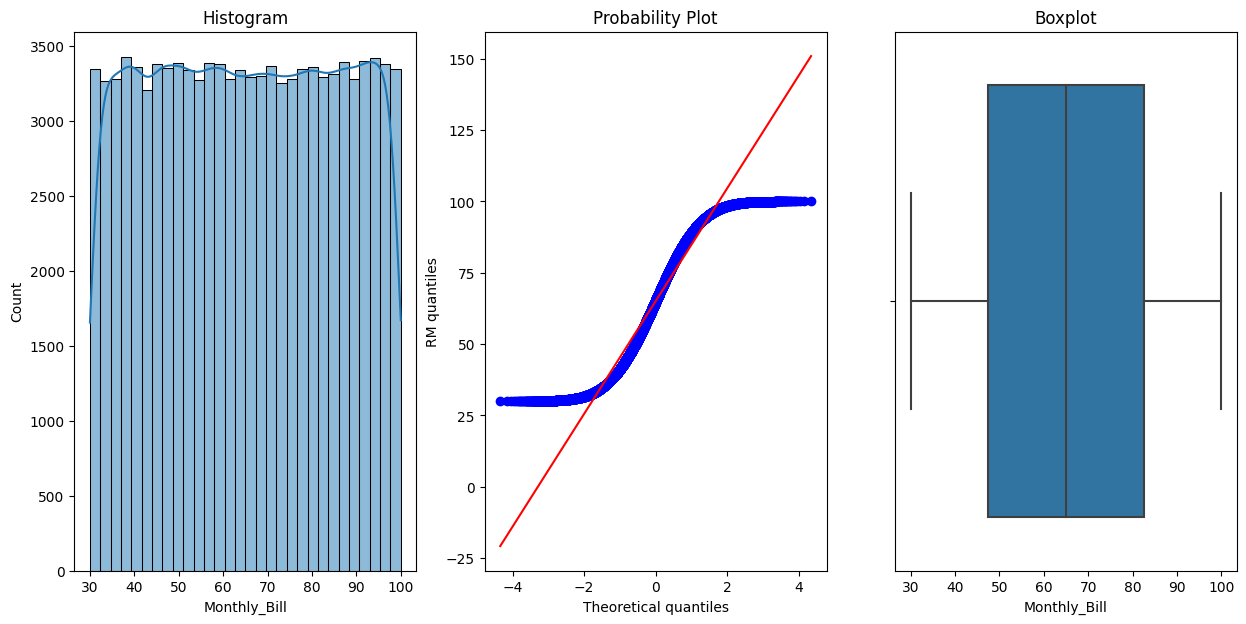

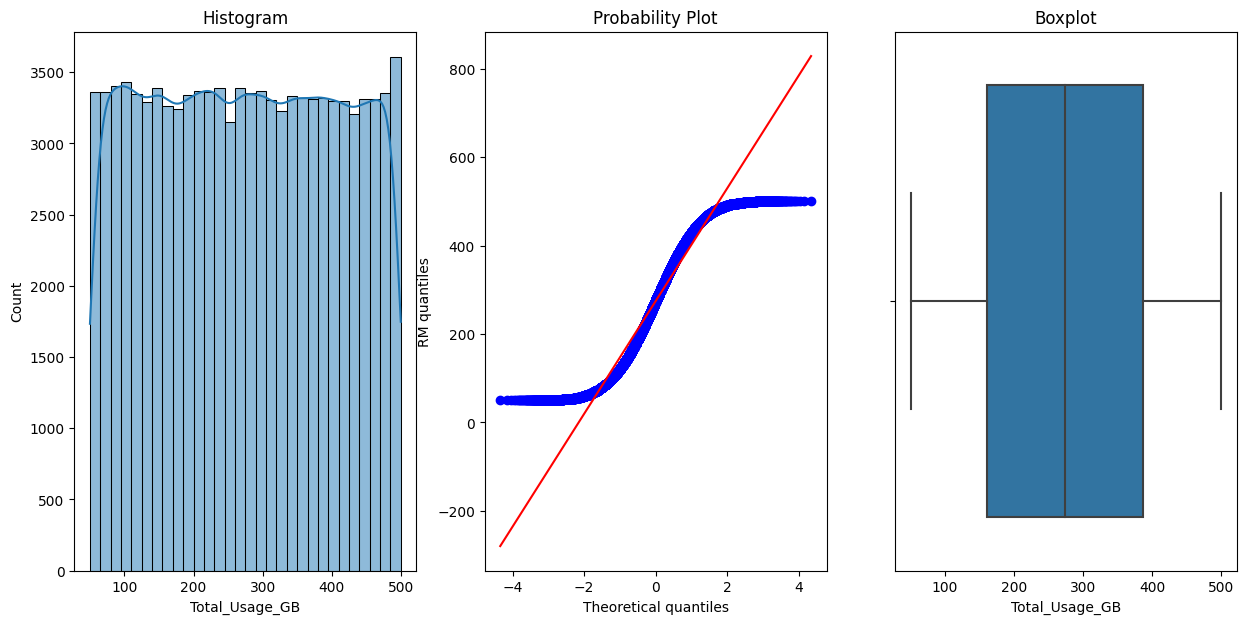

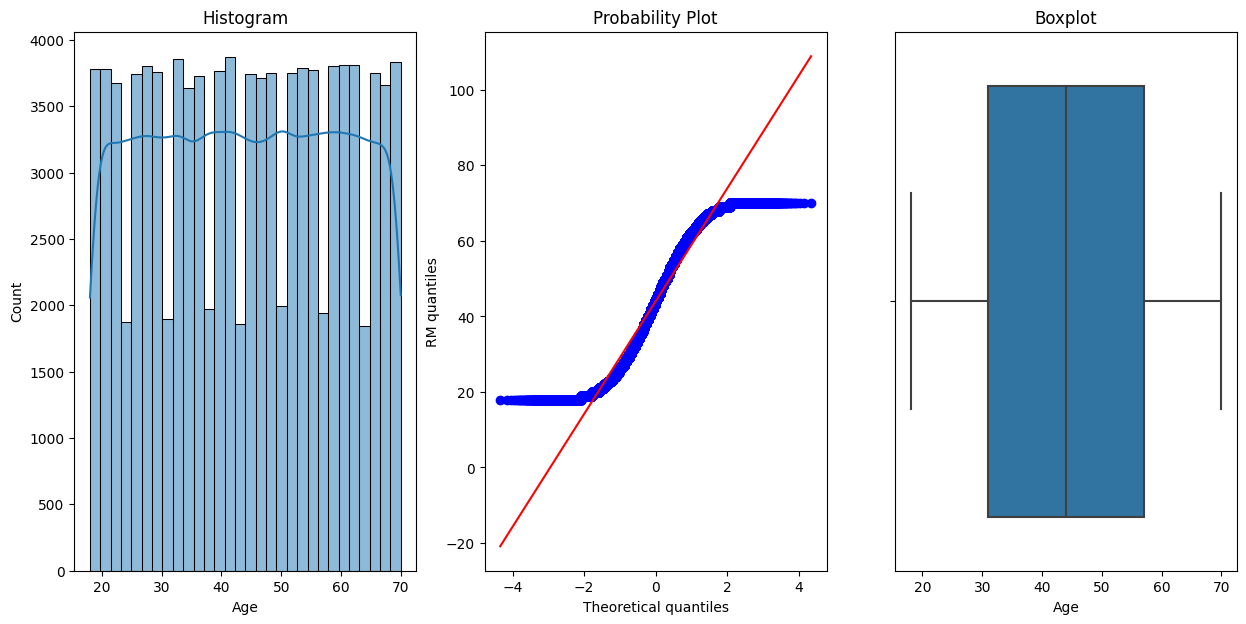

In [46]:
### Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    plt.figure(figsize=(15,7))
    plt.subplot(1, 3, 1)
    sns.histplot(data=data, x=feature, bins=30, kde=True)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)
    stats.probplot(data[feature], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')
    plt.subplot(1, 3, 3)
    sns.boxplot(x=data[feature])
    plt.title('Boxplot')
plt.show()

After ploting histogram probability distribution and box plot to find numerical value are in normally distribution and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset

c)Prepare the data for machine learning by encoding categorical variables.

In [47]:
print(categorical_feature)

{'Gender', 'Location', 'Name'}


In [48]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])

In [49]:
data.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,0,63,1,2,17,73.36,236,0
1,2,11112,62,0,4,1,48.76,172,0
2,3,22223,24,0,2,5,85.47,460,0
3,4,33334,36,0,3,3,97.94,297,1
4,5,44445,46,0,3,19,58.14,266,0


In [50]:
print(data['CustomerID'].nunique())

100000


In [51]:
data.drop(columns=['CustomerID'], inplace=True)

In [52]:
data.drop(columns=['Name'], inplace=True)

In [53]:
# splitting dataset into dependent and independent feature
TempX = data.drop(columns='Churn')
Tempy = data['Churn']

In [54]:
TempX.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB
0,63,1,2,17,73.36,236
1,62,0,4,1,48.76,172
2,24,0,2,5,85.47,460
3,36,0,3,3,97.94,297
4,46,0,3,19,58.14,266


**2. Feature Engineering:**

a)Generate relevant features from the dataset that can help improve the model's prediction
accuracy.

In [55]:
# Feature 1: Average Monthly Usage
data['Average_Monthly_Usage'] = data['Total_Usage_GB'] / data['Subscription_Length_Months']

# Feature 2: Total Bill (Sum of Monthly Bills)
data['Total_Bill'] = data['Monthly_Bill'] * data['Subscription_Length_Months']

# Feature 3: High Bill to Usage Ratio
data['High_Bill_to_Usage_Ratio'] = (data['Monthly_Bill'] / data['Total_Usage_GB']).fillna(0)

# Display the updated dataset
print(data.head())

   Age  Gender  Location  Subscription_Length_Months  Monthly_Bill  \
0   63       1         2                          17         73.36   
1   62       0         4                           1         48.76   
2   24       0         2                           5         85.47   
3   36       0         3                           3         97.94   
4   46       0         3                          19         58.14   

   Total_Usage_GB  Churn  Average_Monthly_Usage  Total_Bill  \
0             236      0              13.882353     1247.12   
1             172      0             172.000000       48.76   
2             460      0              92.000000      427.35   
3             297      1              99.000000      293.82   
4             266      0              14.000000     1104.66   

   High_Bill_to_Usage_Ratio  
0                  0.310847  
1                  0.283488  
2                  0.185804  
3                  0.329764  
4                  0.218571  


In [56]:
# splitting dataset into dependent and independent feature
X = data.drop(columns='Churn')
y = data['Churn']

<Axes: >

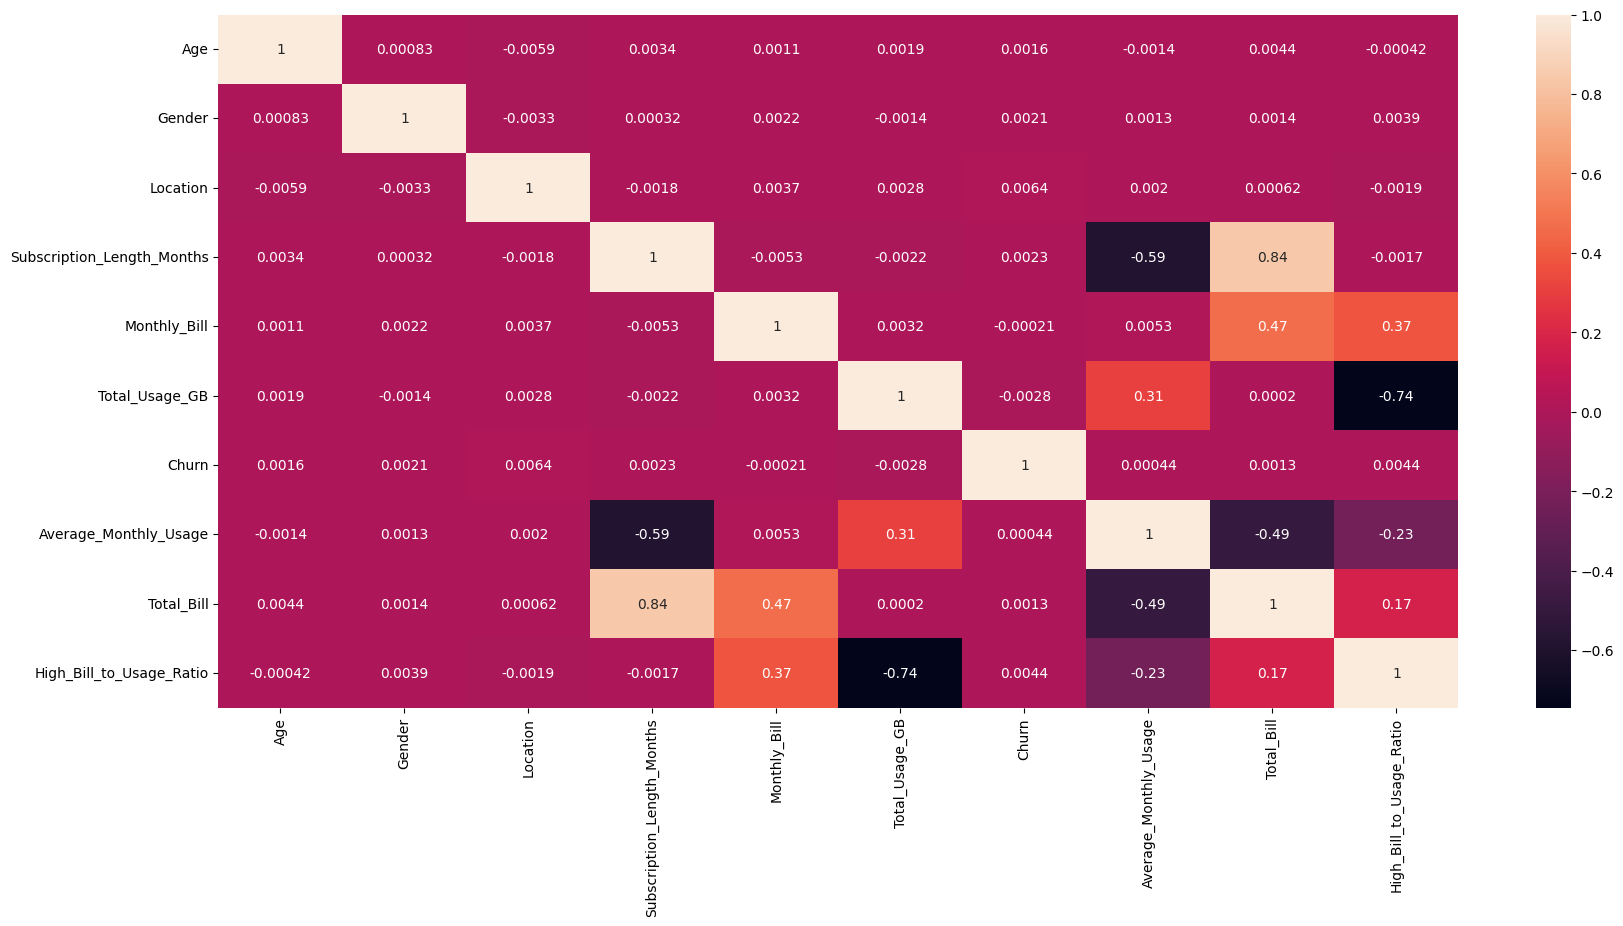

In [57]:
# Finding the correlation between the independent and dependent feature
plt.figure(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)

splitting the data into
training and testing sets.

In [58]:
X_trains, X_tests, y_train, y_test = train_test_split(X, y, test_size=0.2)

Applying Feature Scaling

In [59]:
scalar=StandardScaler()
X_train=scalar.fit_transform(X_trains)
X_test=scalar.fit_transform(X_tests)

In [60]:
X_train.shape

(80000, 9)

In [61]:
X_test.shape

(20000, 9)

**3. Model Building:**

a) Choose appropriate machine learning algorithms (e.g., logistic regression, random forest, or
neural networks).

b) Train and validate the selected model on the training dataset.

c) Evaluate the model's performance using appropriate metrics (e.g., accuracy, precision, recall,
F1-score).

In [62]:
Log_reg =LogisticRegression(C=150,max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.50755
Confusion matrix :
 [[6790 6555]
 [3294 3361]]
Classification report :
               precision    recall  f1-score   support

           0       0.67      0.51      0.58     13345
           1       0.34      0.51      0.41      6655

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.49     20000
weighted avg       0.56      0.51      0.52     20000



In [63]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.49825
Confusion matrix :
 [[5488 5439]
 [4596 4477]]
Classification report :
               precision    recall  f1-score   support

           0       0.54      0.50      0.52     10927
           1       0.45      0.49      0.47      9073

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [64]:
# decisionTree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.49335
Confusion matrix :
 [[5175 5224]
 [4909 4692]]
Classification report :
               precision    recall  f1-score   support

           0       0.51      0.50      0.51     10399
           1       0.47      0.49      0.48      9601

    accuracy                           0.49     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.49      0.49      0.49     20000



**4.Model Optimization**

Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [65]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 40137, 1: 39863})
The number of classes after fit Counter({1: 5149, 0: 5048})


In [66]:
# splitting the over sampling dataset
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [67]:
#decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.5313725490196078
Confusion matrix :
 [[660 571]
 [385 424]]
Classification report :
               precision    recall  f1-score   support

           0       0.63      0.54      0.58      1231
           1       0.43      0.52      0.47       809

    accuracy                           0.53      2040
   macro avg       0.53      0.53      0.53      2040
weighted avg       0.55      0.53      0.54      2040



In [68]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.6372549019607843
Confusion matrix :
 [[638 333]
 [407 662]]
Classification report :
               precision    recall  f1-score   support

           0       0.61      0.66      0.63       971
           1       0.67      0.62      0.64      1069

    accuracy                           0.64      2040
   macro avg       0.64      0.64      0.64      2040
weighted avg       0.64      0.64      0.64      2040



In [69]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.4950980392156863
Confusion matrix :
 [[371 356]
 [674 639]]
Classification report :
               precision    recall  f1-score   support

           0       0.36      0.51      0.42       727
           1       0.64      0.49      0.55      1313

    accuracy                           0.50      2040
   macro avg       0.50      0.50      0.49      2040
weighted avg       0.54      0.50      0.51      2040



In [70]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.5333333333333333
Confusion matrix :
 [[515 422]
 [530 573]]
Classification report :
               precision    recall  f1-score   support

           0       0.49      0.55      0.52       937
           1       0.58      0.52      0.55      1103

    accuracy                           0.53      2040
   macro avg       0.53      0.53      0.53      2040
weighted avg       0.54      0.53      0.53      2040



From this results we get better accuraccy and TP FP ratio in RandomForestClassifier so perform HyperParameter Tunning for this model only

In [71]:
# Define the hyperparameter grid for Grid Search or Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300], # Number of trees in the forest
    'max_depth': [None, 10, 20, 30], # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider when looking for the best split
}

In [72]:
# Create the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

In [73]:
scorer = make_scorer(accuracy_score)

From our 4 model RandomForestClassifier performs better than all. So we dumb our model using pickle library

**5. Model Deployment:**

a)Once satisfied with the model's performance, deploy it into a production-like
environment (you can simulate this in a development environment).

b)Ensure the model can take new customer data as input and provide churn predictions.

Model Saving

In [74]:
import pickle

In [75]:
filename = 'Model.sav'
pickle.dump(Rfc_sampling, open(filename,'wb'))

In [76]:
load_model = pickle.load(open(filename, 'rb'))

In [77]:
load_model.score(X_test, y_test)

0.4994

In [78]:
Age=69
Gender='Male'
Location ='Los Angeles'
Subscription_Length_Months =17
Monthly_Bill=73.36
Total_Usage_GB =236

In [79]:
Gender=Gender.lower()
Location=Location.lower()
High_Bill_to_Usage_Ratio =Monthly_Bill/Total_Usage_GB
Average_Monthly_Usage = Total_Usage_GB / Subscription_Length_Months
Total_Bill = Monthly_Bill * Subscription_Length_Months

In [80]:
data = [[Age,Gender,Location,Subscription_Length_Months,Monthly_Bill, Total_Usage_GB,Average_Monthly_Usage,Total_Bill,High_Bill_to_Usage_Ratio]]
df = pd.DataFrame(data, columns=['Age','Gender','Location','Subscription_Length_Months','Monthly_Bill','Total_Usage_GB','Average_Monthly_Usage','Total_Bill','High_Bill_to_Usage_Ratio'])
df.head()
print(df.dtypes)

Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Average_Monthly_Usage         float64
Total_Bill                    float64
High_Bill_to_Usage_Ratio      float64
dtype: object


In [81]:
for feature in df.columns:
    if df[feature].dtypes == 'O':
        categorical_feature = feature
        print(categorical_feature)

Gender
Location


In [82]:
encoder = LabelEncoder()
for feature in df.columns:
    if df[feature].dtypes == 'O':
        df[feature] = encoder.fit_transform(df[feature])


In [83]:
df.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Average_Monthly_Usage,Total_Bill,High_Bill_to_Usage_Ratio
0,69,0,0,17,73.36,236,13.882353,1247.12,0.310847


In [84]:
single = load_model.predict(df)
probability = load_model.predict_proba(df)[:,1]
print(single)

[0]


In [85]:
print(probability)

[0.37068015]


In [86]:
if single == 1:
    print("This Customer is likely to be Churned!")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("This Customer is likely to be Continue!")
    print(f"Confidence level is {np.round(probability*100, 2)}")

This Customer is likely to be Continue!
Confidence level is [37.07]
